In [1]:
!pip install pymongo

%matplotlib inline

import numpy
import scipy
import scipy.stats
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sea

import pymongo

    100% |████████████████████████████████| 368kB 1.6MB/s 
You are using pip version 8.1.2, however version 9.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
mongo = pymongo.MongoClient('mainmongo', 27017)
records = [i for i in mongo.nutrition.nndb.find()]

In [3]:
print("Record Count:", len(records))

nutrients = dict()
for rec in records:
    descrip = rec['descrip']
    
    for nut in rec['nutrients']:
        nid = nut['nutrient_id']
        val = float(nut['nutrient_val'])
        
        if nid not in nutrients:
            nut['min'] = val
            nut['min_food'] = descrip
            nut['max'] = val
            nut['max_food'] = descrip
            nutrients[nid] = nut
        elif val > 0.0:
            old = nutrients[nid]
            if val < old['min'] or old['min'] <= 0.0:
                old['min'] = val
                old['min_food'] = descrip
            if val > old['max']:
                old['max'] = val
                old['max_food'] = descrip

print("Nutrient Count:", len(nutrients))

Record Count: 8618
Nutrient Count: 150


In [4]:
print("%6s %-20s %12s %-20s %12s %-20s" % ('ID', 'Nutrient', 'MinVal', 'MinFood', 'MaxVal', 'MaxFood'))
print("%6s %-20s %12s %-20s %12s %-20s" % ('---', '-'*20, '-'*12, '-'*20, '-'*12, '-'*20))

for nid, nut in sorted(nutrients.items()):
    print("%6s %-20s %12.3f %-20s %12.3f %-20s" % (
        nid, nut['descrip'][:20], 
        nut['min'], nut['min_food'][:20], 
        nut['max'], nut['max_food'][:20]
    ))

    ID Nutrient                   MinVal MinFood                    MaxVal MaxFood             
   --- -------------------- ------------ -------------------- ------------ --------------------
   203 Protein                     0.010 Tea, instant, sweete       88.320 Soy protein isolate,
   204 Total lipid (fat)           0.010 Sauce, fish, ready-t      100.000 Fat, beef tallow    
   205 Carbohydrate, by dif        0.010 Chicken, skin (drums      100.000 Sweetener, herbal ex
   207 Ash                         0.010 Vanilla extract, imi       99.800 Salt, table         
   208 Energy                      1.000 Beverages, Green tea      902.000 Fat, beef tallow    
   209 Starch                      0.010 Turkey, retail parts       73.770 Rice, white, long-gr
   210 Sucrose                     0.010 Milk, reduced fat, f       99.800 Sugars, granulated  
   211 Glucose (dextrose)          0.010 Milk, reduced fat, f       57.000 Infant formula, MEAD
   212 Fructose                    0.010

In [5]:
def _nutrient_vals(nid):
    for food in records:
        val = 0.0
        for nut in food['nutrients']:
            if nut['nutrient_id'] == nid:
                val = float(nut['nutrient_val'])
                break
        yield val

def nutrient_vals(nid):
    return scipy.array(list(_nutrient_vals(nid)))

In [7]:
vits = pd.DataFrame({
    'B12': nutrient_vals('418'),
    'C': nutrient_vals('401'),
    'D': nutrient_vals('324'),
    'Calcium': nutrient_vals('301'),
})

vits.describe()

,B12,C,Calcium,D
count,8618.000000,8618.000000,8618.000000,8618.000000
mean,1.225260,7.925377,73.411348,14.292527
std,4.319183,57.582758,201.363662,122.674571
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,9.000000,0.000000
50%,0.080000,0.000000,19.000000,0.000000
75%,1.297500,2.500000,62.000000,1.000000
max,98.890000,2400.000000,7364.000000,10000.000000


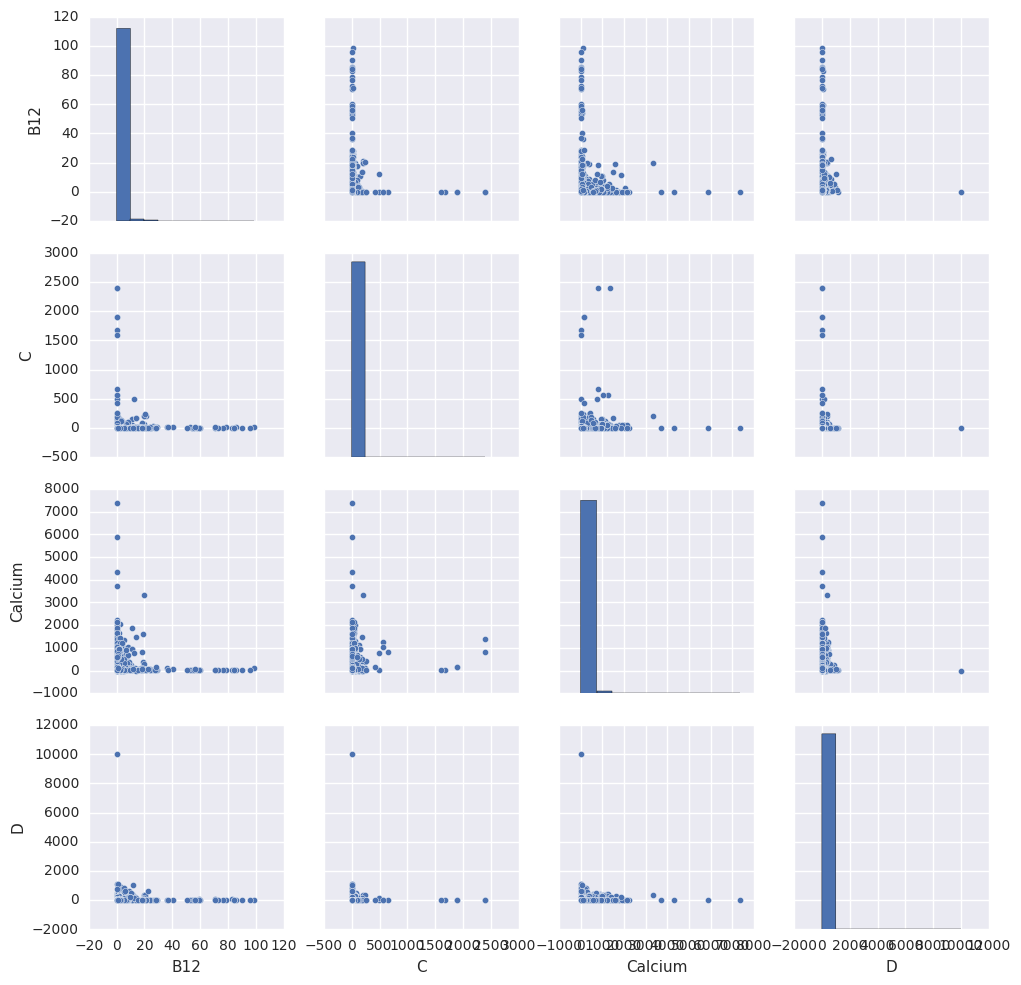

In [9]:
sea.pairplot(vits)